Step 1: Define Social Media Spikes
Identify spike days/weeks/months where social media post volume exceeds the rolling historical mean by more than two standard deviations, indicating statistically significant bursts of attention.

In [ ]:
import pandas as pd

# Load and melt dataset as before
df = pd.read_csv('bluesky_allkeywords.csv')

df_long = pd.melt(
    df,
    id_vars=['company'],
    var_name='date',
    value_name='all_keywords_mentions'
)
df_long['date'] = pd.to_datetime(df_long['date'])

# Mapping company to ticker explicitly
sp500_tickers = ["WMT", "AMZN", "AAPL", "CVS", "TSLA", "GOOGL", "META", "JPM", "COST", "KR",
"WBA", "TGT", "UPS", "CNC", "CI", "MSFT", "VZ", "IBM", "UNH", "XOM",
"MCK", "CVX", "CAH", "HD", "WBA", "MPC", "COR", "F", "C", "DELL",
"GM", "NVDA", "PFE", "PG", "CMCSA", "JNJ", "WFC", "BAC", "ABBV", "SBUX",
"CSCO", "T", "PEP", "INTC", "DIS", "BA", "GS", "MS", "HON", "CRM"
]
company_names = df_long['company'].unique()
company_to_ticker = dict(zip(company_names, sp500_tickers))
df_long['ticker'] = df_long['company'].map(company_to_ticker)

# Drop the original company column
df_long = df_long.drop(columns=['company'])

# Sort for rolling calculation
df_long = df_long.sort_values(['ticker', 'date']).reset_index(drop=True)


         date  all_keywords_mentions ticker
0  2024-08-01                   1363   AAPL
1  2024-08-02                   1409   AAPL
2  2024-08-03                   1277   AAPL
3  2024-08-04                   1221   AAPL
4  2024-08-05                   1347   AAPL
5  2024-08-06                   1322   AAPL
6  2024-08-07                   1373   AAPL
7  2024-08-08                   1289   AAPL
8  2024-08-09                   1322   AAPL
9  2024-08-10                   1147   AAPL
10 2024-08-11                   1044   AAPL
11 2024-08-12                   2176   AAPL
12 2024-08-13                   1647   AAPL
13 2024-08-14                   1579   AAPL
14 2024-08-15                   1452   AAPL
15 2024-08-16                   1467   AAPL
16 2024-08-17                   1216   AAPL
17 2024-08-18                   1285   AAPL
18 2024-08-19                   1470   AAPL
19 2024-08-20                   1421   AAPL
20 2024-08-21                   1361   AAPL
21 2024-08-22                   

In [118]:

# Spike flagging function
def flag_spikes(df, window_size, count_col, flag_col):
    rolling_mean = df.groupby('ticker')[count_col].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())
    rolling_std = df.groupby('ticker')[count_col].transform(lambda x: x.rolling(window=window_size, min_periods=1).std().fillna(0))
    df[flag_col] = df[count_col] > (rolling_mean + 1.5 * rolling_std)
    return df


# Daily spikes
df_long = flag_spikes(df_long, 7, 'all_keywords_mentions', 'daily_spike')
daily_spikes = df_long[df_long['daily_spike']][['date', 'ticker', 'all_keywords_mentions']]

# Weekly spikes
df_weekly = df_long.set_index('date').groupby('ticker')['all_keywords_mentions'].resample('W').sum().reset_index()
df_weekly = df_weekly.sort_values(['ticker', 'date']).reset_index(drop=True)
df_weekly = flag_spikes(df_weekly, 21, 'all_keywords_mentions', 'weekly_spike')
weekly_spikes = df_weekly[df_weekly['weekly_spike']][['date', 'ticker', 'all_keywords_mentions']]

# Monthly spikes
df_monthly = df_long.set_index('date').groupby('ticker')['all_keywords_mentions'].resample('M').sum().reset_index()
df_monthly = df_monthly.sort_values(['ticker', 'date']).reset_index(drop=True)
df_monthly = flag_spikes(df_monthly, 30, 'all_keywords_mentions', 'monthly_spike')
monthly_spikes = df_monthly[df_monthly['monthly_spike']][['date', 'ticker', 'all_keywords_mentions']]

#Biweekly spikes
df_biweekly = df_long.set_index('date').groupby('ticker')['all_keywords_mentions'].resample('2W').sum().reset_index()
df_biweekly= df_biweekly.sort_values(['ticker', 'date']).reset_index(drop=True)
df_biweekly = flag_spikes(df_biweekly, 30, 'all_keywords_mentions', 'biweekly_spike')
biweekly_spikes = df_biweekly[df_biweekly['biweekly_spike']][['date', 'ticker', 'all_keywords_mentions']]

print("Daily Spikes:"
      , daily_spikes)

C:\Users\Thisu\AppData\Local\Temp\ipykernel_17244\2934010967.py:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df_long.set_index('date').groupby('ticker')['all_keywords_mentions'].resample('M').sum().reset_index()


Daily Spikes:             date ticker  all_keywords_mentions
11    2024-08-12   AAPL                   2176
25    2024-08-26   AAPL                   1538
32    2024-09-02   AAPL                   2591
39    2024-09-09   AAPL                   4854
65    2024-10-05   AAPL                   2361
...          ...    ...                    ...
18171 2025-07-02    XOM                     44
18179 2025-07-10    XOM                     42
18187 2025-07-18    XOM                     37
18188 2025-07-19    XOM                    108
18196 2025-07-27    XOM                     27

[1452 rows x 3 columns]


In [107]:
#Download stock data. 

import yfinance as yf
import numpy as np

sp500_tickers = ["WMT", "AMZN", "AAPL", "CVS", "TSLA", "GOOGL", "META", "JPM", "COST", "KR",
"WBA", "TGT", "UPS", "CNC", "CI", "MSFT", "VZ", "IBM", "UNH", "XOM",
"MCK", "CVX", "CAH", "HD", "WBA", "MPC", "COR", "F", "C", "DELL",
"GM", "NVDA", "PFE", "PG", "CMCSA", "JNJ", "WFC", "BAC", "ABBV", "SBUX",
"CSCO", "T", "PEP", "INTC", "DIS", "BA", "GS", "MS", "HON", "CRM"
]

# Get the data for tickers from yahoo finance

# Download Close price data for tickers
stock_data_unordered = yf.download(sp500_tickers, '2023-01-01', '2025-10-02', auto_adjust=True)['Close']

# Download S&P 500 index data
SP500 = yf.download('^GSPC', '2023-01-01', '2025-10-02', auto_adjust=True)['Close']

# Transpose stock data so tickers are row index
stock_data_unordered = stock_data_unordered.T

# Reorder rows by original ticker list order
stock_data = stock_data_unordered.loc[sp500_tickers]
stock_data = stock_data.T

#log returns
log_returns= np.log(stock_data/stock_data.shift(1)).dropna()


#Percentage change in stock returns day-to-day (in lieu of trading day variance)

sd2 = stock_data
pct_change = sd2.pct_change().dropna()
#print(pct_change)
#variance of stock returns over each week in the period (5 trading days) 

weekly_variance = log_returns.rolling(window=5).var().dropna()

#variance of stock returns over each month in the period (21 trading days)

monthly_variance = log_returns.rolling(window=21).var()

#variance of stock returns over each 2 weeks in the period (10 trading days)
biweekly_variance = log_returns.rolling(window=10).var().dropna()

#super averages
#average percent change in a single day

transpose_pct_change = pct_change.T
av_pct_change = transpose_pct_change.mean(axis=1)
#print(av_pct_change)

#average weekly variance
av_weekly_variance = weekly_variance.mean()

#average monthly variance
transpose_monthly = monthly_variance
av_monthly_variance = transpose_monthly.mean()

#average biweekly variance
av_biweekly_variance = biweekly_variance.mean()

print(weekly_variance.at['2023-06-30', 'AAPL'])
#Note: variance windows are in trading days, not calendar days. Moreover, these are backwards looking rolling variances.

[*********************100%***********************]  49 of 49 completed
[*********************100%***********************]  1 of 1 completed

0.00013801255945611354



C:\Users\Thisu\AppData\Local\Temp\ipykernel_17244\4038973784.py:35: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pct_change = sd2.pct_change().dropna()


Step 2: Estimate Post-Spike Returns and Volatility

To estimate log returns, use the ??????
To estimate weekly volatility, use the average weekly volatility for the previous 5 days.
To estimate monthly volatility, use the average monthly volatility for the previous 21 days. 

In [131]:


##Code to get corresponding trading days before/after spikes
import pandas as pd
import pandas_market_calendars as mcal
import numpy as np
# Load NYSE trading calendar
nyse = mcal.get_calendar('NYSE')


def get_trading_day_info(input_date, days_after, days_before):
    """
    Takes a datetime date and returns:
    1. The next trading day
    2. The 5th trading day after the date
    3. A list of trading days within 14 calendar days before the date
    """


 # Generate schedule around the target date
    schedule = nyse.schedule(start_date=date - pd.Timedelta(days=30), end_date=date + pd.Timedelta(days=30))
    trading_days = schedule.index


 # 1. Find the next trading day
    next_idx = trading_days.searchsorted(date, side='left')
    next_trading_day = trading_days[next_idx].date() if next_idx < len(trading_days) else None


    # 2. Find the nth trading day after
    nth_trading_day = trading_days[next_idx + days_after].date() if next_idx + (days_after) < len(trading_days) else None

    #3. Get all trading days within 14 days before the given date
    start_window = date - pd.Timedelta(days=days_before)
    trading_days_before = [d.date() for d in trading_days[(trading_days >= start_window) & (trading_days < date)]]


    return {
    'input_date': date,
    'next_trading_day': next_trading_day,
    'nth_trading_day_after': nth_trading_day,
    'trading_days_before': trading_days_before
    }


#Now, to find trading day info for spikes
#Make an estimation for "expected" weekly volatility and monthly volatility using rolling averages of historical data

columns = ['Date', 'Ticker', 'Spike', 'AbnormalVolatility_weekly']
weekly_sigma_spike = pd.DataFrame(columns=columns)
print(get_value(weekly_variance, 'AAPL', '2023-02-01'))


#Weekly volatility estimation
for i in range(len(weekly_spikes)):
    date = weekly_spikes.iloc[i]['date']
    date = pd.to_datetime(date)
    ticker = weekly_spikes.iloc[i]['ticker']
    info = get_trading_day_info(date, 5, 5)
    info2 = get_trading_day_info(date, 10, 10)
    historical_weekly_volatility = [weekly_variance.at[(pd.to_datetime(d), ticker)] for d in info['trading_days_before']]
    expected_weekly_volatility = sum(historical_weekly_volatility)/len(historical_weekly_volatility)
    historical_biweekly_volatility = [biweekly_variance.at[(pd.to_datetime(d), ticker)] for d in info2['trading_days_before']]
    expected_biweekly_volatility = sum(historical_biweekly_volatility)/len(historical_biweekly_volatility)
    actual_volatility = weekly_variance.at[(pd.to_datetime(info['nth_trading_day_after']), ticker)]
    biactual_volatility = biweekly_variance.at[(pd.to_datetime(info2['nth_trading_day_after']), ticker)]

    abnormal_volatility = np.abs(actual_volatility - expected_weekly_volatility)
    pct_difference = (actual_volatility - expected_weekly_volatility)/expected_weekly_volatility *100

    biabnormal_volatility = np.abs(biactual_volatility - expected_biweekly_volatility)
    bipct_difference = (biactual_volatility - expected_biweekly_volatility)/expected_biweekly_volatility *100
    new_row = pd.DataFrame({
    'Date': [date],
    'Ticker': [ticker],
    'WeeklyVariance': [expected_weekly_volatility],
    'Spike':[indicator],
    'AbnormalVolatility_weekly': [abnormal_volatility],
    'Pct_difference_weekly': [pct_difference], 
    'AbnormalVolatility_biweekly': [biabnormal_volatility],
    'Pct_difference_biweekly': [bipct_difference] })
    weekly_sigma_spike = pd.concat([weekly_sigma_spike, new_row], ignore_index=True)



print(weekly_sigma_spike)

0.00020776893971683158


C:\Users\Thisu\AppData\Local\Temp\ipykernel_17244\4224357091.py:80: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  weekly_sigma_spike = pd.concat([weekly_sigma_spike, new_row], ignore_index=True)


          Date Ticker Spike AbnormalVolatility_weekly WeeklyVariance  \
0   2024-09-08   AAPL     1                  0.000007        0.00022   
1   2024-09-15   AAPL     1                  0.000278       0.000045   
2   2024-11-17   AAPL     1                  0.000097       0.000129   
3   2024-11-24   AAPL     1                  0.000072       0.000098   
4   2024-12-01   AAPL     1                  0.000028       0.000034   
..         ...    ...   ...                       ...            ...   
386 2024-09-01    XOM     1                  0.000233       0.000194   
387 2024-09-08    XOM     1                  0.000302       0.000142   
388 2024-09-29    XOM     1                  0.000191       0.000246   
389 2025-07-13    XOM     1                  0.000008       0.000204   
390 2025-07-20    XOM     1                  0.000057       0.000095   

    Pct_difference_weekly AbnormalVolatility_biweekly Pct_difference_biweekly  
0               -3.305316                    0.000178  

In [ ]:
#repeat for biweekly 

columns = ['Date', 'Ticker', 'Spike', 'AbnormalVolatility']
biweekly_sigma_spike = pd.DataFrame(columns=columns)

#Biweekly volatility estimation
for i in range(len(biweekly_spikes)):
    date = biweekly_spikes.iloc[i]['date']
    date = pd.to_datetime(date)
    ticker = biweekly_spikes.iloc[i]['ticker']
    info = get_trading_day_info(date, 10, 10)
    historical_biweekly_volatility = [biweekly_variance.at[(pd.to_datetime(d), ticker)] for d in info['trading_days_before']]
    expected_biweekly_volatility = sum(historical_biweekly_volatility)/len(historical_biweekly_volatility)
    actual_volatility = biweekly_variance.at[(pd.to_datetime(info['nth_trading_day_after']), ticker)]
    abnormal_volatility = np.abs(actual_volatility - expected_biweekly_volatility)
    abs_pct_change = abnormal_volatility / actual_volatility * 100
    pct_change_signed = (actual_volatility - expected_biweekly_volatility)/actual_volatility *100
    new_row = pd.DataFrame({
    'Date': [date],
    'Ticker': [ticker],
    'BiweeklyVariance': [expected_biweekly_volatility],
    'Spike':[indicator],
    'AbnormalVolatility': [abnormal_volatility],
    'AbsPercentChange': [abs_pct_change],
    'PercentChange': [pct_change_signed]
    })
    biweekly_sigma_spike = pd.concat([biweekly_sigma_spike, new_row], ignore_index=True)

print(biweekly_sigma_spike)

C:\Users\Thisu\AppData\Local\Temp\ipykernel_17244\1459866090.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  biweekly_sigma_spike = pd.concat([biweekly_sigma_spike, new_row], ignore_index=True)


          Date Ticker Spike AbnormalVolatility BiweeklyVariance  \
0   2024-11-24   AAPL     1           0.000074         0.000111   
1   2024-12-08   AAPL     1           0.000081         0.000038   
2   2024-11-24   ABBV     1           0.001658         0.001824   
3   2024-12-22   ABBV     1            0.00004         0.000106   
4   2025-02-02   ABBV     1           0.000207         0.000274   
..         ...    ...   ...                ...              ...   
158 2024-11-24    WMT     1           0.000014         0.000116   
159 2024-12-08    WMT     1           0.000007         0.000116   
160 2025-02-02    WMT     1           0.000053          0.00009   
161 2025-03-02    WMT     1            0.00026         0.000724   
162 2025-05-25    WMT     1            0.00002         0.000095   

    AbsPercentChange PercentChange  
0         200.437974   -200.437974  
1          68.199241     68.199241  
2         997.151248   -997.151248  
3          60.249438    -60.249438  
4         

In [ ]:
#repeat for daily 
columns = ['Date', 'Ticker', 'Spike', 'AbnormalVolatility_daily']
daily_sigma_spike = pd.DataFrame(columns=columns)

for i in range(len(daily_spikes)):
    date = daily_spikes.iloc[i]['date']
    date = pd.to_datetime(date)
    ticker = daily_spikes.iloc[i]['ticker']
    info = get_trading_day_info(date, 1, 5)
    info_weekly = get_trading_day_info(date, 5, 10)
    info_biweekly = get_trading_day_info(date, 10, 20)
    historical_daily_volatility = [pct_change.at[(pd.to_datetime(d), ticker)] for d in info['trading_days_before']]
    expected_daily_volatility = sum(historical_daily_volatility)/len(historical_daily_volatility)
    actual_volatility = pct_change.at[(pd.to_datetime(info['next_trading_day']), ticker)]
    abnormal_volatility = np.abs(actual_volatility - expected_daily_volatility)
    pct_change_signed= (actual_volatility - expected_daily_volatility)/expected_daily_volatility *100

    historical_weekly_volatility = [pct_change.at[(pd.to_datetime(d), ticker)] for d in info_weekly['trading_days_before']]
    expected_weekly_volatility = sum(historical_weekly_volatility)/len(historical_weekly_volatility)
    weekly_actual_volatility = pct_change.at[(pd.to_datetime(info_weekly['next_trading_day']), ticker)]
    weekly_abnormal_volatility = np.abs(weekly_actual_volatility - expected_weekly_volatility)
    weekly_pct_change_signed= (weekly_actual_volatility - expected_weekly_volatility)/expected_weekly_volatility *100

    historical_biweekly_volatility = [pct_change.at[(pd.to_datetime(d), ticker)] for d in info_biweekly['trading_days_before']]
    expected_biweekly_volatility = sum(historical_biweekly_volatility)/len(historical_biweekly_volatility)
    biweekly_actual_volatility = pct_change.at[(pd.to_datetime(info_biweekly['next_trading_day']), ticker)]
    biweekly_abnormal_volatility = np.abs(biweekly_actual_volatility - expected_biweekly_volatility)
    biweekly_pct_change_signed= (biweekly_actual_volatility - expected_weekly_volatility)/expected_weekly_volatility *100

    new_row = pd.DataFrame({
    'Date': [date],
    'Ticker': [ticker],
    'DailyVariance': [expected_daily_volatility],
    'Spike':[indicator],
    'AbnormalVolatility_daily': [abnormal_volatility],
    'pct_change_daily': [pct_change_signed],
    'AbnormalVolatility_weekly': [weekly_abnormal_volatility],
    'pct_change_weekly': [weekly_pct_change_signed],
    'AbnormalVolatility_biweekly': [biweekly_abnormal_volatility],
    'pct_change_biweekly': [biweekly_pct_change_signed],
     })
    daily_sigma_spike = pd.concat([daily_sigma_spike, new_row], ignore_index=True)

print(daily_sigma_spike)

C:\Users\Thisu\AppData\Local\Temp\ipykernel_17244\1960648713.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  daily_sigma_spike = pd.concat([daily_sigma_spike, new_row], ignore_index=True)


           Date Ticker Spike AbnormalVolatility_daily DailyVariance  \
0    2024-08-12   AAPL     1                 0.007159      0.014289   
1    2024-08-26   AAPL     1                 0.000984      0.000514   
2    2024-09-02   AAPL     1                 0.028665       0.00146   
3    2024-09-09   AAPL     1                  0.00331     -0.002902   
4    2024-10-05   AAPL     1                 0.021803     -0.000727   
...         ...    ...   ...                      ...           ...   
1447 2025-07-02    XOM     1                  0.01878     -0.002211   
1448 2025-07-10    XOM     1                 0.005066      0.004863   
1449 2025-07-18    XOM     1                 0.026576     -0.008262   
1450 2025-07-19    XOM     1                 0.016175     -0.013577   
1451 2025-07-27    XOM     1                 0.004009      0.005411   

     pct_change_daily AbnormalVolatility_weekly pct_change_weekly  \
0          -50.102688                  0.008493       -623.079321   
1        

In [139]:
# Load and melt dataset as before
count = pd.read_csv('bluesky_allkeywords.csv')

count_long = pd.melt(
    count,
    id_vars=['company'],
    var_name='date',
    value_name='all_keywords_mentions'
)
count_long['date'] = pd.to_datetime(count_long['date'])

# Mapping company to ticker explicitly
sp500_tickers = ["WMT", "AMZN", "AAPL", "CVS", "TSLA", "GOOGL", "META", "JPM", "COST", "KR",
"WBA", "TGT", "UPS", "CNC", "CI", "MSFT", "VZ", "IBM", "UNH", "XOM",
"MCK", "CVX", "CAH", "HD", "WBA", "MPC", "COR", "F", "C", "DELL",
"GM", "NVDA", "PFE", "PG", "CMCSA", "JNJ", "WFC", "BAC", "ABBV", "SBUX",
"CSCO", "T", "PEP", "INTC", "DIS", "BA", "GS", "MS", "HON", "CRM"
]
company_names = count_long['company'].unique()
company_to_ticker = dict(zip(company_names, sp500_tickers))
count_long['ticker'] = count_long['company'].map(company_to_ticker)

# Drop the original company column
count_long = count_long.drop(columns=['company'])

# Sort for rolling calculation
count_long = count_long.sort_values(['ticker', 'date']).reset_index(drop=True)

count_long.head()

,date,all_keywords_mentions,ticker
0,2024-08-01,1363,AAPL
1,2024-08-02,1409,AAPL
2,2024-08-03,1277,AAPL
3,2024-08-04,1221,AAPL
4,2024-08-05,1347,AAPL


In [141]:

#repeat for daily 
columns = ['Date', 'Ticker', 'Spike', 'AbnormalVolatility_daily']
daily_spike_vs_none= pd.DataFrame(columns=columns)

for i in range(len(count_long)):
    date = count_long.iloc[i]['date']
    date = pd.to_datetime(date)
    ticker = count_long.iloc[i]['ticker']
    info = get_trading_day_info(date, 1, 5)
    info_weekly = get_trading_day_info(date, 5, 10)
    info_biweekly = get_trading_day_info(date, 10, 20)
    historical_daily_volatility = [pct_change.at[(pd.to_datetime(d), ticker)] for d in info['trading_days_before']]
    expected_daily_volatility = sum(historical_daily_volatility)/len(historical_daily_volatility)
    actual_volatility = pct_change.at[(pd.to_datetime(info['next_trading_day']), ticker)]
    abnormal_volatility = np.abs(actual_volatility - expected_daily_volatility)
    pct_change_signed= (actual_volatility - expected_daily_volatility)/expected_daily_volatility *100

    historical_weekly_volatility = [pct_change.at[(pd.to_datetime(d), ticker)] for d in info_weekly['trading_days_before']]
    expected_weekly_volatility = sum(historical_weekly_volatility)/len(historical_weekly_volatility)
    weekly_actual_volatility = pct_change.at[(pd.to_datetime(info_weekly['next_trading_day']), ticker)]
    weekly_abnormal_volatility = np.abs(weekly_actual_volatility - expected_weekly_volatility)
    weekly_pct_change_signed= (weekly_actual_volatility - expected_weekly_volatility)/expected_weekly_volatility *100

    historical_biweekly_volatility = [pct_change.at[(pd.to_datetime(d), ticker)] for d in info_biweekly['trading_days_before']]
    expected_biweekly_volatility = sum(historical_biweekly_volatility)/len(historical_biweekly_volatility)
    biweekly_actual_volatility = pct_change.at[(pd.to_datetime(info_biweekly['next_trading_day']), ticker)]
    biweekly_abnormal_volatility = np.abs(biweekly_actual_volatility - expected_biweekly_volatility)
    biweekly_pct_change_signed= (biweekly_actual_volatility - expected_weekly_volatility)/expected_weekly_volatility *100
    if date in daily_spikes['date'].values and ticker in daily_spikes['ticker'].values:
        indicator = 1
    else:
        indicator = 0

    new_row = pd.DataFrame({
    'Date': [date],
    'Ticker': [ticker],
    'DailyVariance': [expected_daily_volatility],
    'Spike':[indicator],
    'AbnormalVolatility_daily': [abnormal_volatility],
    'pct_change_daily': [pct_change_signed],
    'AbnormalVolatility_weekly': [weekly_abnormal_volatility],
    'pct_change_weekly': [weekly_pct_change_signed],
    'AbnormalVolatility_biweekly': [biweekly_abnormal_volatility],
    'pct_change_biweekly': [biweekly_pct_change_signed],
     })
    daily_spike_vs_none = pd.concat([daily_spike_vs_none, new_row], ignore_index=True)

print(daily_spike_vs_none)

C:\Users\Thisu\AppData\Local\Temp\ipykernel_17244\1556551126.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  daily_spike_vs_none = pd.concat([daily_spike_vs_none, new_row], ignore_index=True)


            Date Ticker Spike AbnormalVolatility_daily DailyVariance  \
0     2024-08-01   AAPL     0                 0.023031       0.00628   
1     2024-08-02   AAPL     0                 0.006347      0.000523   
2     2024-08-03   AAPL     0                 0.049959      0.001792   
3     2024-08-04   AAPL     0                 0.050086      0.001919   
4     2024-08-05   AAPL     1                  0.04987      0.001703   
...          ...    ...   ...                      ...           ...   
18195 2025-07-26    XOM     0                 0.004572      0.004848   
18196 2025-07-27    XOM     1                 0.004009      0.005411   
18197 2025-07-28    XOM     1                 0.003717      0.005703   
18198 2025-07-29    XOM     1                 0.008347      0.004574   
18199 2025-07-30    XOM     1                 0.014956      0.006274   

      pct_change_daily AbnormalVolatility_weekly pct_change_weekly  \
0          -366.712044                  0.015572        1321.3006

In [142]:
daily_spike_vs_none.to_csv('daily_spike_vs_none.csv', index=False)

Step 3: Compare realized volatility/returns with estimated returns/volatility


[-366.7120435978753 1214.3106186272646 -2787.888686689643 ...
 65.1794128432156 182.4743256573631 -238.37720975355285]
[ -366.7120436   1214.31061863 -2787.88868669 ...    65.17941284
   182.47432566  -238.37720975]


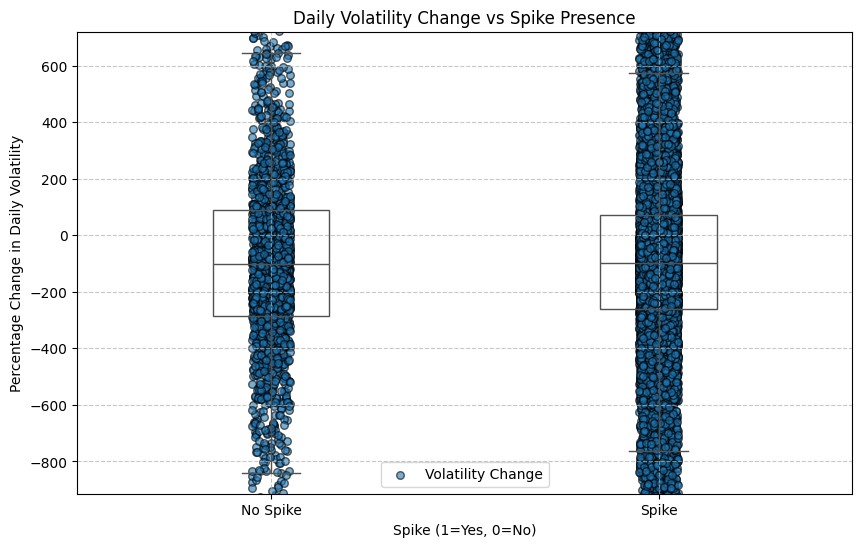

In [160]:
x = daily_spike_vs_none['Spike'].astype(float).values
y = daily_spike_vs_none['pct_change_daily'].values

print(y)

import matplotlib.pyplot as plt
import numpy as np

# Flatten any nested sequences and convert all to float, setting problematic values to NaN
def clean_value(val):
    if isinstance(val, (list, np.ndarray)):
        return float(val[0]) if len(val) > 0 else np.nan
    try:
        return float(val)
    except:
        return np.nan

y_cleaned = np.array([clean_value(v) for v in daily_spike_vs_none['pct_change_daily']])
x = daily_spike_vs_none['Spike'].astype(float).values
print(y_cleaned)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Add jitter for scatter
x_jitter = x + np.random.uniform(-0.05, 0.05, size=len(x))

plt.figure(figsize=(10, 6))

# Scatter with transparency and jitter
plt.scatter(x_jitter, y_cleaned, alpha=0.6, s=30, edgecolor='k', label='Volatility Change')

# Boxplot overlaid
sns.boxplot(x=x, y=y_cleaned, whis=1.5, width=0.3, boxprops={'facecolor':'none'}, showfliers=False)

plt.xlabel('Spike (1=Yes, 0=No)')
plt.ylabel('Percentage Change in Daily Volatility')
plt.title('Daily Volatility Change vs Spike Presence')
plt.xticks([0, 1], ['No Spike', 'Spike'])
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.show()

#repeat for weekly


C:\Users\Thisu\AppData\Local\Temp\ipykernel_17244\2650354792.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Spike', y='y_cleaned', data=df_plot, inner='quartile', palette='Set2')


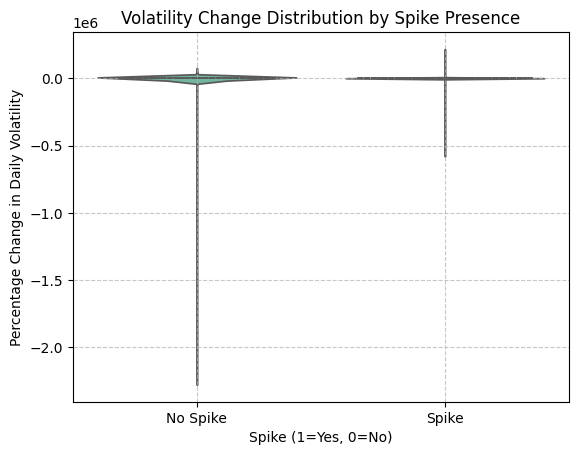

In [163]:
import matplotlib.pyplot as plt
import seaborn as sns

# Suppose your clean y array is named `y_cleaned`
# Ensure the length matches your DataFrame
daily_spike_vs_none['y_cleaned'] = y_cleaned
df_plot = daily_spike_vs_none[['Spike', 'y_cleaned']].dropna()

sns.violinplot(x='Spike', y='y_cleaned', data=df_plot, inner='quartile', palette='Set2')
plt.xlabel('Spike (1=Yes, 0=No)')
plt.ylabel('Percentage Change in Daily Volatility')
plt.title('Volatility Change Distribution by Spike Presence')
plt.xticks([0, 1], ['No Spike', 'Spike'])
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


C:\Users\Thisu\AppData\Local\Temp\ipykernel_17244\1328678455.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Spike', y='y_cleaned', data=df_plot, inner='quartile', palette='Set2')


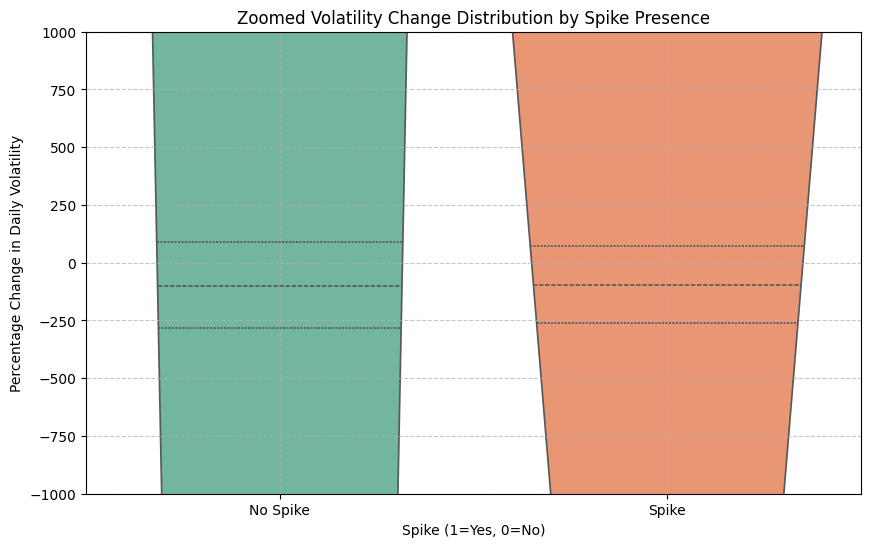

In [164]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='Spike', y='y_cleaned', data=df_plot, inner='quartile', palette='Set2')
plt.xlabel('Spike (1=Yes, 0=No)')
plt.ylabel('Percentage Change in Daily Volatility')
plt.title('Zoomed Volatility Change Distribution by Spike Presence')
plt.xticks([0, 1], ['No Spike', 'Spike'])
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(-1000, 1000)  # Adjust limits to focus on main data
plt.show()


C:\Users\Thisu\AppData\Local\Temp\ipykernel_17244\2441235087.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Spike', y='y_cleaned', data=df_trimmed, inner='quartile', palette='Set2')


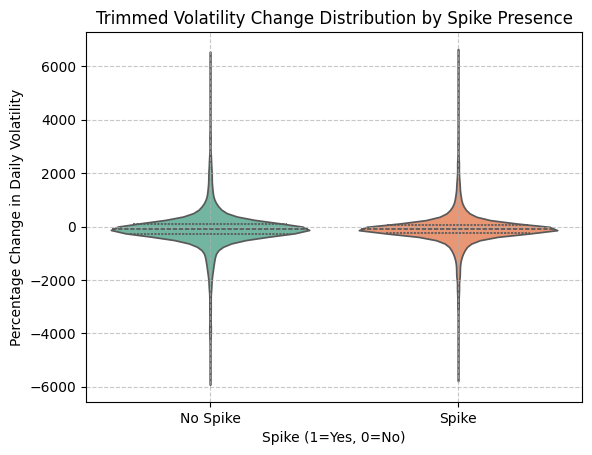

In [165]:
import numpy as np

lower = np.percentile(df_plot['y_cleaned'], 1)
upper = np.percentile(df_plot['y_cleaned'], 99)
df_trimmed = df_plot[(df_plot['y_cleaned'] >= lower) & (df_plot['y_cleaned'] <= upper)]

sns.violinplot(x='Spike', y='y_cleaned', data=df_trimmed, inner='quartile', palette='Set2')
plt.xlabel('Spike (1=Yes, 0=No)')
plt.ylabel('Percentage Change in Daily Volatility')
plt.title('Trimmed Volatility Change Distribution by Spike Presence')
plt.xticks([0, 1], ['No Spike', 'Spike'])
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


In [166]:
print("Stats for No Spike:")
print(df_trimmed[df_trimmed['Spike']==0]['y_cleaned'].describe())
print("\nStats for Spike:")
print(df_trimmed[df_trimmed['Spike']==1]['y_cleaned'].describe())


Stats for No Spike:
count    2427.000000
mean     -106.551974
std       849.716943
min     -5576.292348
25%      -274.301730
50%      -100.550703
75%        81.588762
max      6202.420008
Name: y_cleaned, dtype: float64

Stats for Spike:
count    14695.000000
mean       -87.320097
std        832.167029
min      -5551.074284
25%       -255.555075
50%        -97.298819
75%         67.799948
max       6410.359569
Name: y_cleaned, dtype: float64


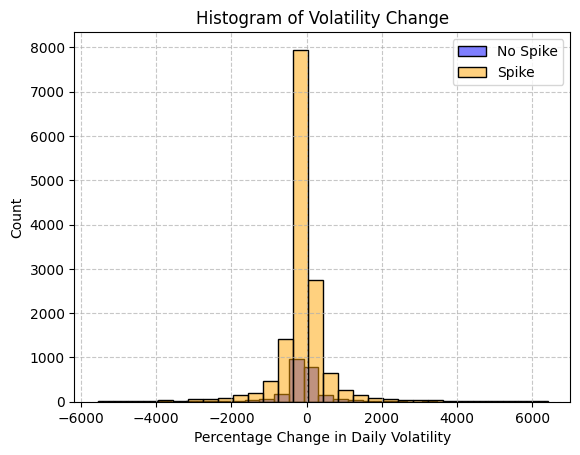

In [167]:
sns.histplot(df_trimmed[df_trimmed['Spike']==0]['y_cleaned'], color='blue', label='No Spike', alpha=0.5, bins=30)
sns.histplot(df_trimmed[df_trimmed['Spike']==1]['y_cleaned'], color='orange', label='Spike', alpha=0.5, bins=30)
plt.legend()
plt.xlabel('Percentage Change in Daily Volatility')
plt.title('Histogram of Volatility Change')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


[1321.3006803409328 -323.2227886105241 1617.3572974035544 ...
 -633.4502663913554 130.31368330944727 -230.4555214105772]
[1321.30068034 -323.22278861 1617.3572974  ... -633.45026639  130.31368331
 -230.45552141]


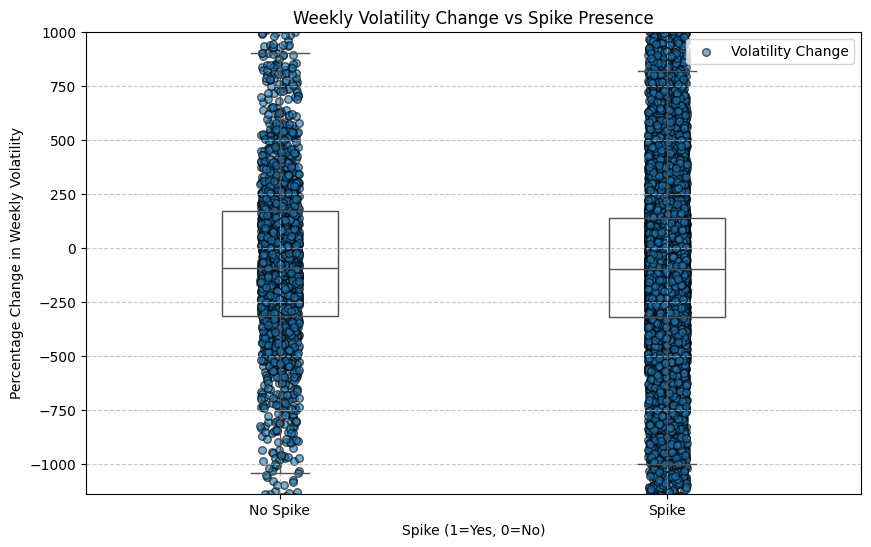

In [158]:
x = daily_spike_vs_none['Spike'].astype(float).values
y = daily_spike_vs_none['pct_change_weekly'].values

print(y)

import matplotlib.pyplot as plt
import numpy as np

# Flatten any nested sequences and convert all to float, setting problematic values to NaN
def clean_value(val):
    if isinstance(val, (list, np.ndarray)):
        return float(val[0]) if len(val) > 0 else np.nan
    try:
        return float(val)
    except:
        return np.nan

y_cleaned = np.array([clean_value(v) for v in daily_spike_vs_none['pct_change_weekly']])
x = daily_spike_vs_none['Spike'].astype(float).values
print(y_cleaned)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Add jitter for scatter
x_jitter = x + np.random.uniform(-0.05, 0.05, size=len(x))

plt.figure(figsize=(10, 6))

# Scatter with transparency and jitter
plt.scatter(x_jitter, y_cleaned, alpha=0.6, s=30, edgecolor='k', label='Volatility Change')

# Boxplot overlaid
sns.boxplot(x=x, y=y_cleaned, whis=1.5, width=0.3, boxprops={'facecolor':'none'}, showfliers=False)

plt.xlabel('Spike (1=Yes, 0=No)')
plt.ylabel('Percentage Change in Weekly Volatility')
plt.title('Weekly Volatility Change vs Spike Presence')
plt.xticks([0, 1], ['No Spike', 'Spike'])
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.show()

Step 4: Regress abnormal returns and abnormal volatility on social media spike indicators controlling for market index